# Mapa interactivo de accidentes con escooters en Londres

Se utiliza el análisis realizado en esta liga: https://github.com/fajrunwm/escooter/blob/main/london_escooter_accident.ipynb

Para temas de visualización se utiliza la librería folium y solo el año 2022

In [2]:
import pandas as pd
import geopandas as gpd
import os
import urllib.request
import zipfile
import matplotlib.pyplot as plt
import folium
#heatmap
from folium.plugins import HeatMap

In [3]:
os.chdir("G:/Mi unidad/datos")

In [4]:
datalondon="https://data.london.gov.uk/download/statistical-gis-boundary-files-london/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip"

In [5]:

# Descargar el archivo
urllib.request.urlretrieve(datalondon, "london_wards.zip")

# Descomprimir el archivo
with zipfile.ZipFile("london_wards.zip", "r") as z:
    z.extractall("london_wards")
#Eliminar zip
os.remove("london_wards.zip")

In [6]:
# Shapefile de los barrios de Londres
london_ward = gpd.read_file('london_wards/London-wards-2018_ESRI/London_Ward_CityMerged.shp')
#Columnas en minúsculas
london_ward.columns = map(str.lower, london_ward.columns)
london_ward

,name,gss_code,district,lagsscode,hectares,nonld_area,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.000,"POLYGON ((516401.596 160201.802, 516407.302 16..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.000,"POLYGON ((519552.998 164295.600, 519508.096 16..."
2,Berrylands,E05000401,Kingston upon Thames,E09000021,145.390,0.000,"POLYGON ((518107.499 167303.399, 518114.301 16..."
3,Alexandra,E05000400,Kingston upon Thames,E09000021,268.506,0.000,"POLYGON ((520336.700 165105.498, 520332.198 16..."
4,Beverley,E05000402,Kingston upon Thames,E09000021,187.821,0.000,"POLYGON ((521201.203 169275.505, 521204.303 16..."
...,...,...,...,...,...,...,...
628,Whalebone,E05000042,Barking and Dagenham,E09000002,155.399,0.000,"POLYGON ((549410.698 187450.702, 549391.199 18..."
629,Eastbrook,E05000030,Barking and Dagenham,E09000002,345.060,0.000,"POLYGON ((549991.497 184928.504, 549988.899 18..."
630,Chadwell Heath,E05000029,Barking and Dagenham,E09000002,338.422,0.000,"POLYGON ((548874.200 188496.303, 548843.199 18..."
631,Parsloes,E05000037,Barking and Dagenham,E09000002,124.384,0.000,"POLYGON ((547381.597 185753.598, 547377.499 18..."


## Archivos de accidentes en Reino Unido

In [7]:
uk_vehicle=pd.read_csv("https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-vehicle-last-5-years.csv",low_memory=False)
uk_collision = pd.read_csv("https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-collision-last-5-years.csv",low_memory=False)
uk_casualty= pd.read_csv("https://data.dft.gov.uk/road-accidents-safety-data/dft-road-casualty-statistics-casualty-last-5-years.csv",low_memory=False)

In [8]:
# Pegar los tres archivos
uk_accident = pd.merge(uk_vehicle, uk_collision, on="accident_index").merge(uk_casualty, on="accident_index")
uk_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331943 entries, 0 to 1331942
Data columns (total 81 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   accident_index                               1331943 non-null  object 
 1   accident_year_x                              1331943 non-null  int64  
 2   accident_reference_x                         1331943 non-null  object 
 3   vehicle_reference_x                          1331943 non-null  int64  
 4   vehicle_type                                 1331943 non-null  int64  
 5   towing_and_articulation                      1331943 non-null  int64  
 6   vehicle_manoeuvre                            1331943 non-null  int64  
 7   vehicle_direction_from                       1331943 non-null  int64  
 8   vehicle_direction_to                         1331943 non-null  int64  
 9   vehicle_location_restricted_lane             1

In [9]:
necessary_columns = [0,1,4,30,31,38,39,40,62]

# Trim by keeping only necessary columns
uk_accident = uk_accident.iloc[:,necessary_columns]

# Then rename the column 'easting' and 'northing'
uk_accident.rename(columns={'location_easting_osgr': 'easting', 'location_northing_osgr': 'northing'}, inplace=True)

# Check how many columns it has after the trim
uk_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331943 entries, 0 to 1331942
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   accident_index             1331943 non-null  object 
 1   accident_year_x            1331943 non-null  int64  
 2   vehicle_type               1331943 non-null  int64  
 3   easting                    1331608 non-null  float64
 4   northing                   1331608 non-null  float64
 5   date                       1331943 non-null  object 
 6   day_of_week                1331943 non-null  int64  
 7   time                       1331943 non-null  object 
 8   lsoa_of_accident_location  1331943 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 91.5+ MB


In [10]:
escooter_uk_accident = uk_accident[uk_accident["vehicle_type"] == 90]

escooter_uk_accident

,accident_index,accident_year_x,vehicle_type,easting,northing,date,day_of_week,time,lsoa_of_accident_location
29,2018010080992,2018,90,535450.0,181190.0,01/01/2018,2,03:00,E01004305
64,2018010081054,2018,90,531320.0,189860.0,01/01/2018,2,16:25,E01002031
114,2018010081164,2018,90,526310.0,164140.0,02/01/2018,3,14:03,E01004137
183,2018010081298,2018,90,523950.0,196420.0,03/01/2018,4,02:20,E01000248
469,2018010081843,2018,90,507630.0,187900.0,06/01/2018,7,10:38,E01002441
...,...,...,...,...,...,...,...,...,...
1331735,2022991257718,2022,90,317941.0,697493.0,15/12/2022,5,11:15,-1
1331746,2022991257784,2022,90,264257.0,654976.0,28/12/2022,4,13:25,-1
1331747,2022991257784,2022,90,264257.0,654976.0,28/12/2022,4,13:25,-1
1331833,2022991259105,2022,90,276369.0,665438.0,12/12/2022,2,15:10,-1


In [11]:
# Remover filas con valores nulos en easting y northing
escooter_uk_accident = escooter_uk_accident.dropna(subset=["northing", "easting"])
escooter_uk_accident_point = gpd.GeoDataFrame(escooter_uk_accident, 
                                        crs = 'EPSG:27700',
                                        geometry=gpd.points_from_xy(escooter_uk_accident.easting, escooter_uk_accident.northing)
                                       )
escooter_uk_accident_point

,accident_index,accident_year_x,vehicle_type,easting,northing,date,day_of_week,time,lsoa_of_accident_location,geometry
29,2018010080992,2018,90,535450.0,181190.0,01/01/2018,2,03:00,E01004305,POINT (535450.000 181190.000)
64,2018010081054,2018,90,531320.0,189860.0,01/01/2018,2,16:25,E01002031,POINT (531320.000 189860.000)
114,2018010081164,2018,90,526310.0,164140.0,02/01/2018,3,14:03,E01004137,POINT (526310.000 164140.000)
183,2018010081298,2018,90,523950.0,196420.0,03/01/2018,4,02:20,E01000248,POINT (523950.000 196420.000)
469,2018010081843,2018,90,507630.0,187900.0,06/01/2018,7,10:38,E01002441,POINT (507630.000 187900.000)
...,...,...,...,...,...,...,...,...,...,...
1331735,2022991257718,2022,90,317941.0,697493.0,15/12/2022,5,11:15,-1,POINT (317941.000 697493.000)
1331746,2022991257784,2022,90,264257.0,654976.0,28/12/2022,4,13:25,-1,POINT (264257.000 654976.000)
1331747,2022991257784,2022,90,264257.0,654976.0,28/12/2022,4,13:25,-1,POINT (264257.000 654976.000)
1331833,2022991259105,2022,90,276369.0,665438.0,12/12/2022,2,15:10,-1,POINT (276369.000 665438.000)


In [12]:
# Spatial subset/clip accident points by London ward
escooter_london_accident_point = gpd.clip(escooter_uk_accident_point, london_ward)

# Check how many rows it has within London boundary
escooter_london_accident_point

,accident_index,accident_year_x,vehicle_type,easting,northing,date,day_of_week,time,lsoa_of_accident_location,geometry
366005,2019010228526,2019,90,525839.0,163830.0,31/12/2019,3,17:20,E01004142,POINT (525839.000 163830.000)
33678,2018010126361,2018,90,525950.0,163900.0,10/08/2018,6,11:50,E01004142,POINT (525950.000 163900.000)
15546,2018010103741,2018,90,529290.0,158070.0,24/04/2018,3,14:06,E01001027,POINT (529290.000 158070.000)
839024,2021010303360,2021,90,529377.0,159023.0,23/04/2021,6,18:00,E01001027,POINT (529377.000 159023.000)
639677,2020010270728,2020,90,529794.0,159216.0,27/09/2020,1,19:45,E01001023,POINT (529794.000 159216.000)
...,...,...,...,...,...,...,...,...,...,...
320477,2019010168130,2019,90,526203.0,195618.0,09/03/2019,7,13:53,E01000270,POINT (526203.000 195618.000)
330768,2019010182198,2019,90,525519.0,195752.0,21/05/2019,3,11:43,E01000268,POINT (525519.000 195752.000)
874979,2021010349255,2021,90,525031.0,196093.0,05/12/2021,1,17:30,E01000288,POINT (525031.000 196093.000)
1098315,2022010385125,2022,90,526542.0,196182.0,28/06/2022,3,08:55,E01000171,POINT (526542.000 196182.000)


In [13]:
#Cambiar a coordenadas latitud y longitud
escooter_london_accident_point = escooter_london_accident_point.to_crs('EPSG:4326')
#Obtener lat y lon
escooter_london_accident_point['lat'] = escooter_london_accident_point['geometry'].y
escooter_london_accident_point['lon'] = escooter_london_accident_point['geometry'].x

#Eliminar columna easting, northing
escooter_london_accident_point = escooter_london_accident_point.drop(columns=['easting', 'northing'])
#Convertir a dataframe
escooter_london_accident_point = pd.DataFrame(escooter_london_accident_point)
#Filtrar 2022
escooter_london_accident_point = escooter_london_accident_point[escooter_london_accident_point["accident_year_x"]==2022]

In [36]:
#Mapa de accidentes con escooters
#Mapa de londres con capa de google hybrid
m = folium.Map(location=[51.5074, -0.1278], zoom_start=12, tiles='http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}', attr="Google")

# Gradiente de colores
gradient = {0.4: 'yellow', 0.65: 'orange', 1: 'red'}

# Heatmap
HeatMap(data=escooter_london_accident_point[['lat', 'lon']], radius=12, max_zoom=8, gradient=gradient).add_to(m)

# Mapa
m


In [37]:
#Salvar mapa
m.save("escooter_london_accident_heatmap.html")

Text(0, 0.5, 'Número de accidentes')

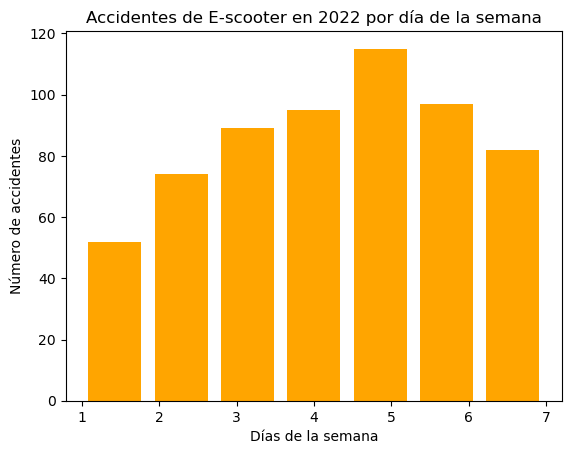

In [35]:
#Histograma de tiempo
escooter_london_accident_point['day_of_week'].plot(kind='hist', bins=7, rwidth=0.8, color='orange')
plt.title('Accidentes de E-scooter en 2022 por día de la semana')
plt.xlabel('Días de la semana')
plt.ylabel('Número de accidentes')